In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
all_data = pd.read_csv('/content/gdrive/My Drive/Project_DL/weather_solar_data_updated.csv')

In [0]:
print(all_data)

             Date  Hour  Cloud_coverage  Visibility  Temperature  Dew_point  \
0       1/31/2016    24            0.00        5.00         1.40       0.89   
1        2/1/2016     1            0.00        7.88         1.16       0.62   
2        2/1/2016     2            0.00        9.84         1.22       0.96   
3        2/1/2016     3            0.00        9.84         1.02       0.61   
4        2/1/2016     4            0.00        9.88         0.83       0.45   
5        2/1/2016     5            0.00        9.84         0.77       0.10   
6        2/1/2016     6            0.00        9.92         0.37      -0.01   
7        2/1/2016     7            0.00       10.00         0.47      -0.04   
8        2/1/2016     8            0.14        9.92         0.89       0.30   
9        2/1/2016     9            0.92       10.00         1.97       0.41   
10       2/1/2016    10            0.46       10.00         3.15       1.07   
11       2/1/2016    11            0.42       10.00 

In [0]:
print(all_data.columns)

Index(['Date', 'Hour', 'Cloud_coverage', 'Visibility', 'Temperature',
       'Dew_point', 'Relative_humidity', 'Wind_speed', 'Station_pressure',
       'Altimeter', 'Solar_energy', 'Sun_elevation'],
      dtype='object')


In [0]:
slength = len(all_data.Hour)
print(slength)

14328


In [0]:
no_days = slength/24
no_days = int(no_days)
print(no_days)

597


In [0]:
new_data = all_data.copy()
#new_data = new_data.drop(range(0,slength),axis=0)
#for num in range(0,no_days):
#  new_data = new_data.append(all_data.iloc[num*24+2:num*24+23,:])
new_data = new_data.drop('Date', axis=1)

In [0]:
!pip install -q sklearn

In [0]:
from __future__ import absolute_import, division, print_function

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 79.9MB 537kB/s 
     |████████████████████████████████| 3.0MB 31.3MB/s 
     |████████████████████████████████| 419kB 49.4MB/s 
     |████████████████████████████████| 61kB 25.4MB/s 


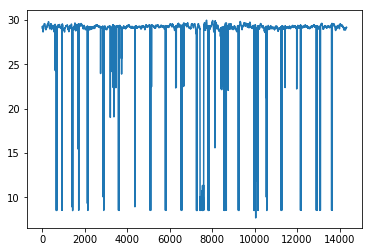

In [0]:
plt.plot(new_data['Station_pressure'])

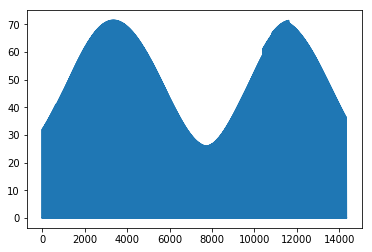

In [0]:
plt.plot(new_data['Sun_elevation'])

In [0]:
dataframe = new_data
train, val = train_test_split(dataframe, test_size=0.35)
tmp, test = train_test_split(dataframe, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')

9313 train examples
5015 validation examples


In [0]:
mean = train.mean(axis = 0) # we need these for normalization of the input data
tmp = train - mean
std = tmp.std(axis=0)
mean = mean.drop('Solar_energy',axis=0)
std = std.drop('Solar_energy',axis=0)

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Solar_energy') # this is a regression problem, 
  #"labels" are in fact targets here
  dataframe -= mean
  dataframe /= std
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 16
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [0]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of targets:', label_batch )

Every feature: ['Hour', 'Cloud_coverage', 'Visibility', 'Temperature', 'Dew_point', 'Relative_humidity', 'Wind_speed', 'Station_pressure', 'Altimeter', 'Sun_elevation']
A batch of targets: tf.Tensor(
[   0.     0.  2666.     0.     0.     0.     0.     0.     0.     0.
    0.     0.  2861.5    0.     0.     0. ], shape=(16,), dtype=float32)


In [0]:
example_batch = next(iter(train_ds))[0]

In [0]:
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [0]:
feature_columns = []

# numeric cols
for header in ['Hour','Cloud_coverage', 'Visibility' ,'Temperature', 'Dew_point','Relative_humidity', 'Station_pressure' ,'Wind_speed', 'Sun_elevation']:
  feature_columns.append(feature_column.numeric_column(header))
  
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  #layers.Dense(256, activation='relu'),
  #layers.Dense(256, activation='relu'),
  #layers.Dense(256, activation='relu'),
  #layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [0]:
EPOCHS = 70
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=EPOCHS)

W0501 23:33:53.405086 140146499643264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Epoch 1/70
583/583 [==============================] - 10s 18ms/step - loss: 590828.6859 - mae: 598.4655 - val_loss: 257041.0715 - val_mae: 277.0688
Epoch 2/70
583/583 [==============================] - 11s 19ms/step - loss: 252343.5617 - mae: 279.4300 - val_loss: 232468.9717 - val_mae: 254.0946
Epoch 3/70
583/583 [==============================] - 10s 18ms/step - loss: 230946.2889 - mae: 265.7047 - val_loss: 212028.7796 - val_mae: 238.0889
Epoch 4/70
583/583 [==============================] - 10s 18ms/step - loss: 220607.5928 - mae: 257.0424 - val_loss: 202950.9556 - val_mae: 230.5009
Epoch 5/70
583/583 [==============================] - 10s 18ms/step - loss: 214202.3671 - mae: 250.6156 - val_loss: 203925.7708 - val_mae: 229.2849
Epoch 6/70
583/583 [==============================] - 10s 18ms/step - loss: 205825.7405 - mae: 245.2084 - val_loss: 196034.7599 - val_mae: 223.1422
Epoch 7/70
583/583 [==============================] - 10s 17ms/step - loss: 201466.7570 - mae: 239.6254 - val_lo

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2560      
_________________________________________________________________
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dense_2 (Dense)              multiple                  65792     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  257       
Total params: 134,401
Trainable params: 134,401
Non-trainable params: 0
__________________________________________________

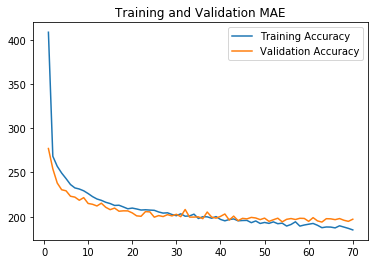

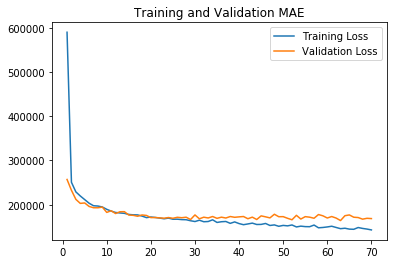

In [0]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')
plt.show()


plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')
plt.show()

In [0]:
loss, mae = model.evaluate(train_ds)
print("MAE", mae)

In [0]:
# Save the weights
#model.save_weights('/content/gdrive/My Drive/Project_DL/checkpoints/checkpoint_05_01')

In [0]:
dataframe = new_data
#train, test = train_test_split(dataframe, test_size=0.5)
train = dataframe

nominal_error_stats = np.zeros(len(train))
predicted_powers = np.zeros(len(train))
observed_powers = np.zeros(len(train))

for num in range(0,len(train)):
  print(num)
  df = train.iloc[num,:]
  df = df.copy()
  label = df.pop('Solar_energy')
  observed_powers[num] = label
  df -= mean
  df /= std
  ds = tf.data.Dataset.from_tensors((dict(df), label))  
  ds = ds.batch(1)
  tmp = ds.take(1)
  loss, mae = model.evaluate(tmp)
  nominal_error_stats[num] = mae
  predicted_powers[num] = model.predict(tmp)

0
1/1 [==============================] - 0s 7ms/step - loss: 6.5399 - mae: 2.5573
1
1/1 [==============================] - 0s 6ms/step - loss: 0.7371 - mae: 0.8586
2
1/1 [==============================] - 0s 6ms/step - loss: 0.8443 - mae: 0.9189
3
1/1 [==============================] - 0s 6ms/step - loss: 0.0042 - mae: 0.0649
4
1/1 [==============================] - 0s 6ms/step - loss: 1.2489 - mae: 1.1176
5
1/1 [==============================] - 0s 6ms/step - loss: 11.7327 - mae: 3.4253
6
1/1 [==============================] - 0s 6ms/step - loss: 74.9211 - mae: 8.6557
7
1/1 [==============================] - 0s 9ms/step - loss: 15383.3027 - mae: 124.0294
8
1/1 [==============================] - 0s 5ms/step - loss: 185322.1562 - mae: 430.4906
9
1/1 [==============================] - 0s 6ms/step - loss: 118909.5938 - mae: 344.8327
10
1/1 [==============================] - 0s 5ms/step - loss: 10151.7432 - mae: 100.7559
11
1/1 [==============================] - 0s 6ms/step - loss: 478954.

In [0]:
#nominal_error_stats.tofile("/content/gdrive/My Drive/Project_DL/nominal_errors_updated")
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/nominal_error_stats_all_updated.csv", delimiter=",", X=nominal_error_stats)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/predicted_powers_all.csv", delimiter=",", X=predicted_powers)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/observed_powers_all.csv", delimiter=",", X=observed_powers)

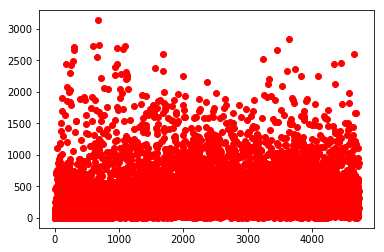

In [0]:
plt.plot(observed_powers, nominal_error_stats, 'ro', label='Error vs. Observed Power')
plt.show()

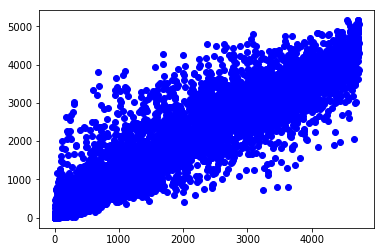

In [0]:
plt.plot(observed_powers, predicted_powers, 'bo', label='Predicted Power vs. Observed Power')

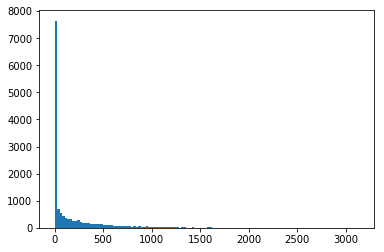

In [0]:
tmp = nominal_error_stats.copy() 
plt.hist(nominal_error_stats,bins=120)
plt.show()

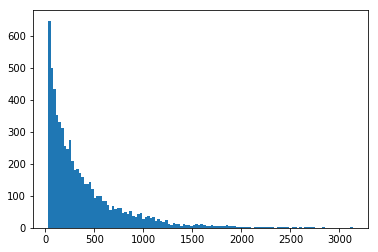

In [0]:
tmp = nominal_error_stats.copy() 
plt.hist(nominal_error_stats[nominal_error_stats>30],bins=120)
plt.show()

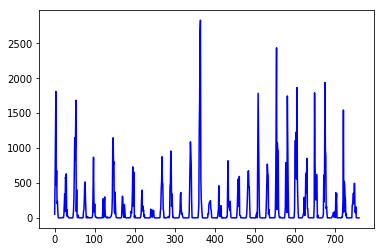

In [0]:
plt.plot(nominal_error_stats[8000:8761], 'b')

In [0]:
print(np.mean(nominal_error_stats[nominal_error_stats>0]))

181.84293093520415


In [0]:
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/mean.csv", delimiter=",", X=mean)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/std.csv", delimiter=",", X=std)

We next restore the weights and continue on the performance evaluation:

In [0]:
def create_model():
  model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
  ])
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

# Restore the weights
new_model = create_model()
new_model.load_weights('/content/gdrive/My Drive/Project_DL/checkpoints/checkpoint_05_01')

In [0]:
EPOCHS = 0
history = new_model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=EPOCHS)

In [0]:
train_ds = df_to_dataset(train, batch_size=len(train))
loss, mae = new_model.evaluate(train_ds)
print("MAE", mae)

1/1 [==============================] - 0s 129ms/step - loss: 145215.3906 - mae: 184.5446
MAE 184.54462


In [0]:
#mean = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/mean.csv", delimiter=",")
#std = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/std.csv", delimiter=",")
#print(mean)
#print(std)

In [0]:
nominal_error_stats_2 = np.fromfile("/content/gdrive/My Drive/Project_DL/nominal_errors_updated")

In [0]:
print(np.mean(nominal_error_stats_2))

181.84293093520415


In [0]:
tmp_errs = nominal_error_stats_2.copy()
tmp_errs = tmp_errs[1:8761]
print(len(tmp_errs))
errors_night = np.zeros(3285)
errors_day = np.zeros(5475)  # 5:00 am - 8:00 pm
for num in range(0,365):
  errors_night[num*9:num*9+5] = tmp_errs[num*24:num*24+5]
  errors_day[num*15:num*15+15] = tmp_errs[num*24+5:num*24+20]  
  errors_night[num*9+5:num*9+9] = tmp_errs[num*24+20:num*24+24]

8760


In [0]:
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/errors_night.csv", delimiter=",", X=errors_night)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/errors_day.csv", delimiter=",", X=errors_day)

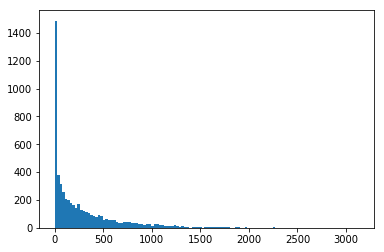

In [0]:
plt.hist(errors_day,bins=120)
plt.show()

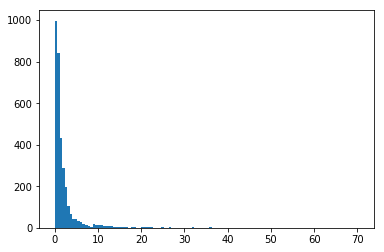

In [0]:
plt.hist(errors_night,bins=120)
plt.show()

In [0]:
from math import log
decision_stat = 0.0
alpha = 0.1
decision_stat_beta = 0.0
beta = 0.05
decision_stat_gamma = 0.0
gamma = 0.01
decision_stat_zeta = 0.0
zeta = 0.2

new_data2 = all_data.copy()
new_data2 = new_data2.drop('Date', axis=1)

vlength = len(new_data2)
dec_stat_vec = np.zeros(vlength)
dec_stat_vec_beta = np.zeros(vlength)
dec_stat_vec_gamma = np.zeros(vlength)
dec_stat_vec_zeta = np.zeros(vlength)
tail_prob_vec = np.zeros(vlength)

for num in range(0,vlength-2):
  mae = nominal_error_stats_2[num+1]
  
  rem = num % 24
  if  rem < 5:
    tail_prob = sum(errors_night > mae)/len(errors_night)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_night)) 
  elif rem >= 20:
    tail_prob = sum(errors_night > mae)/len(errors_night)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_night))
  else:
    tail_prob = sum(errors_day > mae)/len(errors_day)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_day))
  
  tail_prob_vec[num] = tail_prob
  
  decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
  dec_stat_vec[num] = decision_stat
  decision_stat_beta = max(0.0, decision_stat_beta+log(beta/tail_prob))
  dec_stat_vec_beta[num] = decision_stat_beta
  decision_stat_gamma = max(0.0, decision_stat_gamma+log(gamma/tail_prob))
  dec_stat_vec_gamma[num] = decision_stat_gamma
  decision_stat_zeta = max(0.0, decision_stat_zeta+log(zeta/tail_prob))
  dec_stat_vec_zeta[num] = decision_stat_zeta
  

In [0]:
#tail_prob_vec.tofile("/content/gdrive/My Drive/Project_DL/tail_prob_vec")
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/tail_probabilities_all.csv", delimiter=",", X=tail_prob_vec)  
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p1_all.csv", delimiter=",", X=dec_stat_vec)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p01_all.csv", delimiter=",", X=dec_stat_vec_gamma)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p05_all.csv", delimiter=",", X=dec_stat_vec_beta)
#np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p2_all.csv", delimiter=",", X=dec_stat_vec_zeta)

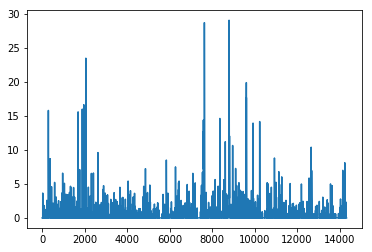

In [0]:
time_range = range(1, vlength+1)
plt.plot(time_range, dec_stat_vec, label='Decision Statistic') # 0.1
plt.show()

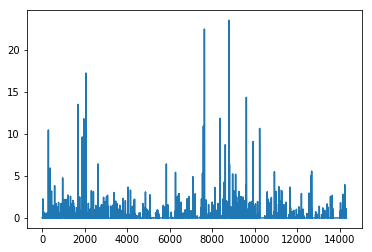

In [0]:
time_range = range(1, vlength+1)
plt.plot(time_range, dec_stat_vec_beta, label='Decision Statistic') # 0.05
plt.show()

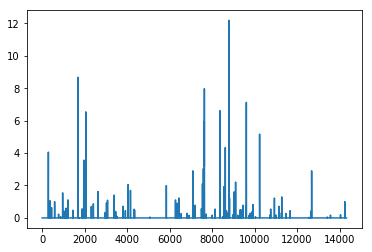

In [0]:
time_range = range(1, vlength+1)
plt.plot(time_range, dec_stat_vec_gamma, label='Decision Statistic') # 0.01
plt.show()

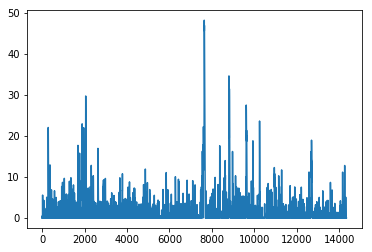

In [0]:
time_range = range(1, vlength+1)
plt.plot(time_range, dec_stat_vec_zeta, label='Decision Statistic') # 0.2
plt.show()

A

**Note:** Compute the tail probabilities for each data point only once and record them, then the rest will be just randomly shuffling these (preserving daily and seasonal properties) so no need to employ the deep network in the performance evaluations

In [0]:
predicted_powers = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/predicted_powers_all.csv", delimiter=",")
observed_powers = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/observed_powers_all.csv", delimiter=",")
tail_prob_vec = np.fromfile("/content/gdrive/My Drive/Project_DL/tail_prob_vec")

In [0]:
winter_hourly_nominal_errors = np.zeros((82,24))
winter_hourly_predicted_powers = np.zeros((82,24))
winter_hourly_observed_powers = np.zeros((82,24))
winter_hourly_tail_probs = np.zeros((82,24))

spring_hourly_nominal_errors = np.zeros((84,24))
spring_hourly_predicted_powers = np.zeros((84,24)) 
spring_hourly_observed_powers = np.zeros((84,24)) 
spring_hourly_tail_probs = np.zeros((84,24)) 

summer_hourly_nominal_errors = np.zeros((69,24)) 
summer_hourly_predicted_powers = np.zeros((69,24))
summer_hourly_observed_powers = np.zeros((69,24))
summer_hourly_tail_probs = np.zeros((69,24)) 

fall_hourly_nominal_errors = np.zeros((87,24))
fall_hourly_predicted_powers = np.zeros((87,24))
fall_hourly_observed_powers = np.zeros((87,24)) 
fall_hourly_tail_probs = np.zeros((87,24)) 

In [0]:
print(all_data['Date'][6577])
print(all_data['Hour'][6577])

11/1/2016
1


In [0]:
for num in range(0,30):
  fall_hourly_nominal_errors[num,:] = nominal_error_stats_2[6577+num*24:6577+num*24+24] # next fall num: 30, next index: 7297
  fall_hourly_predicted_powers[num,:] = predicted_powers[6577+num*24:6577+num*24+24]
  fall_hourly_observed_powers[num,:] = observed_powers[6577+num*24:6577+num*24+24]
  fall_hourly_tail_probs[num,:] = tail_prob_vec[6576+num*24:6576+num*24+24]

In [0]:
for num in range(0,19):
  winter_hourly_nominal_errors[num,:] = nominal_error_stats_2[7297+num*24:7297+num*24+24] # next winter num: 19, next index: 7753
  winter_hourly_predicted_powers[num,:] = predicted_powers[7297+num*24:7297+num*24+24]
  winter_hourly_observed_powers[num,:] = observed_powers[7297+num*24:7297+num*24+24]
  winter_hourly_tail_probs[num,:] = tail_prob_vec[7296+num*24:7296+num*24+24]

In [0]:
for num in range(0,63):
  winter_hourly_nominal_errors[num+19,:] = nominal_error_stats_2[7753+num*24:7753+num*24+24] # next index: 9265
  winter_hourly_predicted_powers[num+19,:] = predicted_powers[7753+num*24:7753+num*24+24]
  winter_hourly_observed_powers[num+19,:] = observed_powers[7753+num*24:7753+num*24+24]
  winter_hourly_tail_probs[num+19,:] = tail_prob_vec[7752+num*24:7752+num*24+24]

In [0]:
for num in range(0,47):
  spring_hourly_nominal_errors[num,:] = nominal_error_stats_2[9265+num*24:9265+num*24+24] # next spring num: 47, next index: 10393
  spring_hourly_predicted_powers[num,:] = predicted_powers[9265+num*24:9265+num*24+24]
  spring_hourly_observed_powers[num,:] = observed_powers[9265+num*24:9265+num*24+24]
  spring_hourly_tail_probs[num,:] = tail_prob_vec[9264+num*24:9264+num*24+24]

In [0]:
for num in range(0,18):
  spring_hourly_nominal_errors[num+47,:] = nominal_error_stats_2[10393+num*24:10393+num*24+24] # next spring num: 65, next index: 10825
  spring_hourly_predicted_powers[num+47,:] = predicted_powers[10393+num*24:10393+num*24+24]
  spring_hourly_observed_powers[num+47,:] = observed_powers[10393+num*24:10393+num*24+24]
  spring_hourly_tail_probs[num+47,:] = tail_prob_vec[10392+num*24:10392+num*24+24]

In [0]:
for num in range(0,19):
  spring_hourly_nominal_errors[num+65,:] = nominal_error_stats_2[10825+num*24:10825+num*24+24] # next index: 11281
  spring_hourly_predicted_powers[num+65,:] = predicted_powers[10825+num*24:10825+num*24+24]
  spring_hourly_observed_powers[num+65,:] = observed_powers[10825+num*24:10825+num*24+24]
  spring_hourly_tail_probs[num+65,:] = tail_prob_vec[10824+num*24:10824+num*24+24]

In [0]:
for num in range(0,14):
  summer_hourly_nominal_errors[num,:] = nominal_error_stats_2[11281+num*24:11281+num*24+24] # next spring num: 14, next index: 11617 
  summer_hourly_predicted_powers[num,:] = predicted_powers[11281+num*24:11281+num*24+24]
  summer_hourly_observed_powers[num,:] = observed_powers[11281+num*24:11281+num*24+24]
  summer_hourly_tail_probs[num,:] = tail_prob_vec[11280+num*24:11280+num*24+24]

In [0]:
for num in range(0,55):
  summer_hourly_nominal_errors[num+14,:] = nominal_error_stats_2[11617+num*24:11617+num*24+24] # next index: 12937
  summer_hourly_predicted_powers[num+14,:] = predicted_powers[11617+num*24:11617+num*24+24]
  summer_hourly_observed_powers[num+14,:] = observed_powers[11617+num*24:11617+num*24+24]
  summer_hourly_tail_probs[num+14,:] = tail_prob_vec[11616+num*24:11616+num*24+24]

In [0]:
for num in range(0,57):
  fall_hourly_nominal_errors[num+30,:] = nominal_error_stats_2[12937+num*24:12937+num*24+24] # next fall num: 90, next index: 14305
  fall_hourly_predicted_powers[num+30,:] = predicted_powers[12937+num*24:12937+num*24+24]
  fall_hourly_observed_powers[num+30,:] = observed_powers[12937+num*24:12937+num*24+24]
  fall_hourly_tail_probs[num+30,:] = tail_prob_vec[12936+num*24:12936+num*24+24]

In [0]:
fall_hourly_tail_probs[14,0]

0.4888888888888889

Average False Alarm Period Calculations:

In [0]:
def frange(x, y, jump):
  arr = []
  while x < y:
    arr = np.append(arr,x)
    x += jump
  return arr  
h = frange(0.01, 14.0, 0.05)
#print(h)
print(h[len(h)-1])

13.960000000000065


In [0]:
from math import log
alpha = 0.2
no_trials = 5000 # number of trials
avg_fap = np.zeros(len(h))
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 0 # time
  k = 1 # day index: btw 1 and 365
  while alarm_flag[len(h)-1] == 0:
    #print(t)
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      tail_prob = winter_hourly_tail_probs[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      tail_prob = spring_hourly_tail_probs[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      tail_prob = summer_hourly_tail_probs[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      tail_prob = fall_hourly_tail_probs[rand_ind,rem]  
      if k==365:
        k = 0       
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_fap = avg_fap + (t+1)*(decision_stat >= h)*(alarm_flag == 0)
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if rem==23:
      k = k+1
    t = t+1
avg_fap = avg_fap/no_trials       
avg_fap.tofile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2.csv", delimiter=",", X=avg_fap) 


In [0]:
print(avg_fap)

[5.16680000e+00 5.28240000e+00 5.43420000e+00 5.54920000e+00
 5.58300000e+00 5.83220000e+00 5.95780000e+00 6.12180000e+00
 6.24860000e+00 6.48880000e+00 6.65120000e+00 6.98700000e+00
 7.18100000e+00 7.64880000e+00 7.93960000e+00 8.40940000e+00
 8.68500000e+00 8.92880000e+00 9.24080000e+00 9.40020000e+00
 9.71860000e+00 1.00620000e+01 1.06728000e+01 1.10954000e+01
 1.13040000e+01 1.17182000e+01 1.21332000e+01 1.25142000e+01
 1.29354000e+01 1.32436000e+01 1.35236000e+01 1.39902000e+01
 1.47658000e+01 1.51818000e+01 1.57152000e+01 1.62680000e+01
 1.67238000e+01 1.71312000e+01 1.74362000e+01 1.80918000e+01
 1.86710000e+01 1.89578000e+01 1.93468000e+01 1.99182000e+01
 2.03056000e+01 2.06218000e+01 2.09868000e+01 2.14290000e+01
 2.20436000e+01 2.26756000e+01 2.31048000e+01 2.39190000e+01
 2.44262000e+01 2.47758000e+01 2.54200000e+01 2.60674000e+01
 2.65970000e+01 2.75984000e+01 2.83478000e+01 2.87918000e+01
 2.94386000e+01 3.03212000e+01 3.10044000e+01 3.18596000e+01
 3.38964000e+01 3.474500

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


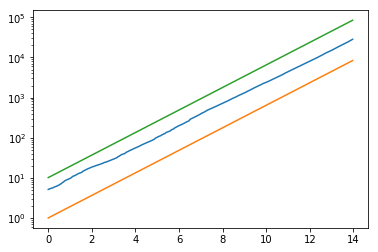

In [0]:
import scipy
low_bnd_fap = np.exp((1-(scipy.special.lambertw(alpha*log(alpha)))/(log(alpha)))*h) # Theoretical (Asymptotic) Lower Bound
apprx_fap =  10.1*low_bnd_fap # Theoretical (Asymptotic) Approximation
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
plt.semilogy(h, avg_fap, label='FAP') 
plt.semilogy(h, low_bnd_fap, label='Lower Bound') 
plt.semilogy(h, apprx_fap, label='Approximation') 
plt.show()

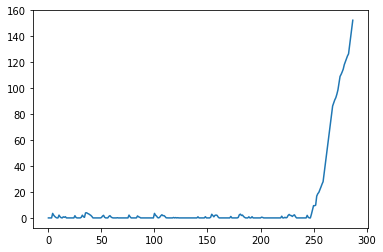

In [0]:
from math import log
alpha = 0.2
decision_stat = 0
dec_stat_vec = np.zeros(288)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
t = 0 # time
while t<288:
  rem = t % 24 # hour index: btw 0 and 23
  rand_ind = np.random.randint(84)
  if t<248:
    tail_prob = spring_hourly_tail_probs[rand_ind,rem]
  else:
    pred_power = spring_hourly_predicted_powers[rand_ind,rem] 
    obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
  decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
  dec_stat_vec[t] = decision_stat
  if rem==23:
    k = k+1  
  t = t+1
 
plt.plot(dec_stat_vec)
plt.show()

In [0]:
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/sample_path_1000_1500_alpha_0p2.csv", delimiter=",", X=dec_stat_vec) 

Average Detection Delay and True Positive Rate Calculations:

Case 1: False Data Injection Attack:

In [0]:
from math import log
alpha = 0.2
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 8 # time
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    #if np.random.normal(0, 1) > 0:
      #sign = 1
    #else:
      #sign = -1
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      if rem>=8 and rem<=15: # attack happens between 8 am - 4 pm
        obs_power = winter_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = summer_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = fall_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = fall_hourly_observed_powers[rand_ind,rem]        
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2")

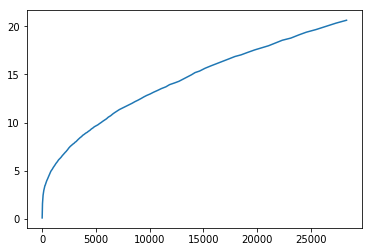

In [0]:
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

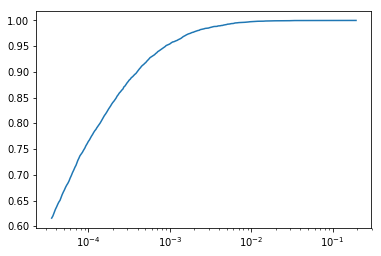

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Anomaly: 50% Performance Reduction:

In [0]:
from math import log
alpha = 0.2
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0.5*winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*fall_hourly_observed_powers[rand_ind,rem]   
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

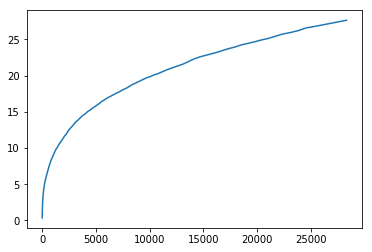

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

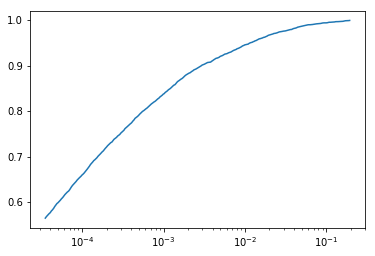

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Anomaly: Shutdown Error or DoS Attack

In [0]:
from math import log
alpha = 0.2
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0  
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_alpha_0p2.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_alpha_0p2.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

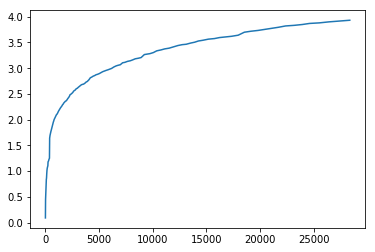

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_alpha_0p2")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_alpha_0p2")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

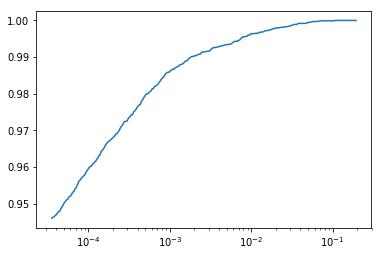

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

**Benchmark Test: Outlier Detector based on Prediction Errors**

Average False Alarm Period

In [0]:
def frange(x, y, jump):
  arr = []
  while x < y:
    arr = np.append(arr,x)
    x += jump
  return arr  
h = frange(0.01, 2800.1, 1)
#print(h)
print(h[len(h)-1])

2800.01


In [0]:
no_trials = 5000 # number of trials
avg_fap = np.zeros(len(h))
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  t = 0 # time
  k = 1 # day index: btw 1 and 365
  while alarm_flag[len(h)-1] == 0:
    #print(t)
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      mae = winter_hourly_nominal_errors[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      mae = spring_hourly_nominal_errors[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      mae = summer_hourly_nominal_errors[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      mae = fall_hourly_nominal_errors[rand_ind,rem]  
      if k==365:
        k = 0       
    decision_stat = mae
    avg_fap = avg_fap + (t+1)*(decision_stat >= h)*(alarm_flag == 0)
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if rem==23:
      k = k+1
    t = t+1
avg_fap = avg_fap/no_trials  
avg_fap.tofile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector.csv", delimiter=",", X=avg_fap) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
print(avg_fap)

[1.0108000e+00 2.6084000e+00 3.5858000e+00 ... 7.6725984e+03 7.6725984e+03
 7.6725984e+03]


Average Detection Delay and True Positive Rate

Case 1: FDI Attack

In [0]:
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  t = 8 # initial time, also change-point
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      if rem>=8 and rem<=15: # attack happens between 8 am - 4 pm
        obs_power = winter_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = summer_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = fall_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = fall_hourly_observed_powers[rand_ind,rem]        
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    decision_stat = mae
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8 hours)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

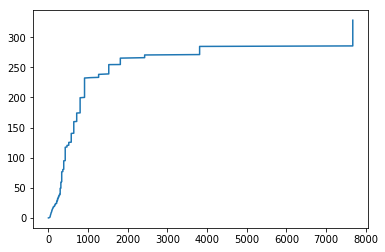

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

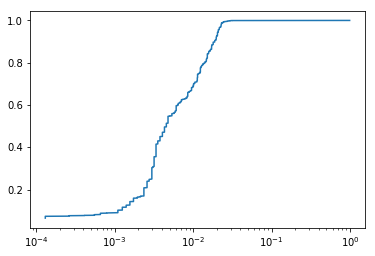

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Case 2: 50% Performance Reduction

In [0]:
from math import log
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0.5*winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*fall_hourly_observed_powers[rand_ind,rem]   
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error   
    decision_stat = mae
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

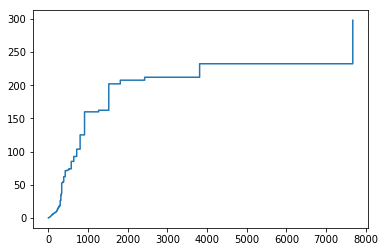

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

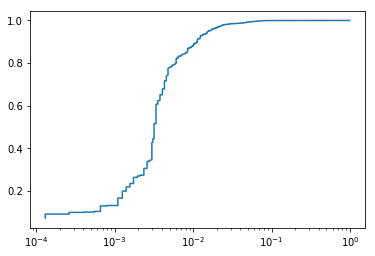

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Case 3: Shotdown/DoS (100% Performance Loss)

In [0]:
from math import log
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  print(num)
  alarm_flag = np.zeros(len(h))
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0 
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error   
    decision_stat = mae
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
print(avg_det_delay)   
print(true_positive_rate)
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_outlier_detector.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_outlier_detector.csv", delimiter=",", X=true_positive_rate) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

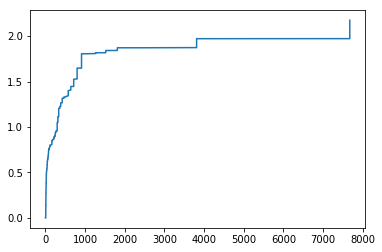

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_DoS_outlier_detector")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_DoS_outlier_detector")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

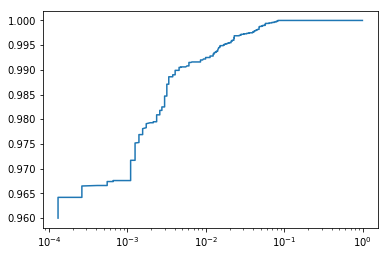

In [0]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()